# V1.2

**Avtor:** Viktor Rackov


In [1]:
import os, numpy as np, matplotlib.pyplot as plt
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

NUM_WORDS = 3000
VAL_SPLIT = 10000
EPOCHS = 30
BATCH_SIZE = 512
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print(tf.__version__)


2.20.0


## Nalaganje IMDB in *multi-hot* vektorizacija


In [2]:
def vectorize_sequences(sequences, dimension=NUM_WORDS):
    result = np.zeros((len(sequences), dimension), dtype="float32")
    for i, seq in enumerate(sequences):
        idx = np.unique([w for w in seq if 0 <= w < dimension])
        result[i, idx] = 1.0
    return result

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)
x_train_vec = vectorize_sequences(x_train, NUM_WORDS)
x_test_vec  = vectorize_sequences(x_test, NUM_WORDS)
x_train_vec.shape, x_test_vec.shape


((25000, 3000), (25000, 3000))

## Razdelitev na učenje/validacijo in model


In [3]:
x_val, y_val = x_train_vec[:VAL_SPLIT], y_train[:VAL_SPLIT]
partial_x_train, partial_y_train = x_train_vec[VAL_SPLIT:], y_train[VAL_SPLIT:]

model = keras.Sequential([
    keras.Input(shape=(NUM_WORDS,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │        12,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,029 (46.99 KB)

 Trainable params: 12,029 (46.99 KB)

 Non-trainable params: 0 (0.00 B)

## Učenje


In [4]:
history = model.fit(
    partial_x_train, partial_y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    verbose=2
)


Epoch 1/30
30/30 - 0s - 15ms/step - accuracy: 0.6372 - loss: 0.6567 - val_accuracy: 0.7200 - val_loss: 0.6024
Epoch 2/30
30/30 - 0s - 2ms/step - accuracy: 0.7827 - loss: 0.5636 - val_accuracy: 0.7921 - val_loss: 0.5373
Epoch 3/30
30/30 - 0s - 2ms/step - accuracy: 0.8383 - loss: 0.5080 - val_accuracy: 0.8112 - val_loss: 0.5079
Epoch 4/30
30/30 - 0s - 2ms/step - accuracy: 0.8671 - loss: 0.4762 - val_accuracy: 0.8209 - val_loss: 0.4942
Epoch 5/30
30/30 - 0s - 2ms/step - accuracy: 0.8820 - loss: 0.4544 - val_accuracy: 0.8337 - val_loss: 0.4819
Epoch 6/30
30/30 - 0s - 2ms/step - accuracy: 0.8946 - loss: 0.4367 - val_accuracy: 0.8484 - val_loss: 0.4686
Epoch 7/30
30/30 - 0s - 2ms/step - accuracy: 0.9028 - loss: 0.4217 - val_accuracy: 0.8664 - val_loss: 0.4574
Epoch 8/30
30/30 - 0s - 2ms/step - accuracy: 0.9077 - loss: 0.4080 - val_accuracy: 0.8724 - val_loss: 0.4502
Epoch 9/30
30/30 - 0s - 2ms/step - accuracy: 0.9099 - loss: 0.3964 - val_accuracy: 0.8730 - val_loss: 0.4449
Epoch 10/30
30/30 

## Grafi izgube in točnosti


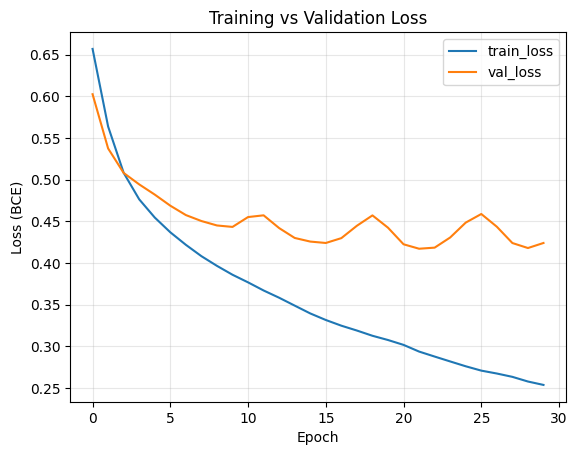

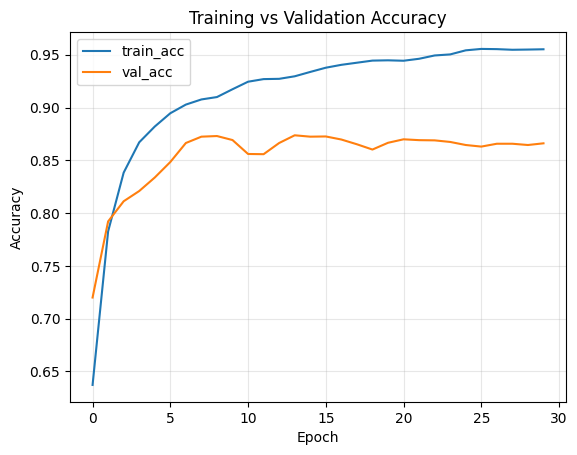

In [5]:
hist = history.history

# Loss
plt.figure()
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss (BCE)'); plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Accuracy
plt.figure()
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training vs Validation Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()  


## Detekcija prekomernega prileganja (overfitting)


In [6]:
import numpy as np
val_loss = np.array(hist['val_loss'], dtype=float)
loss = np.array(hist['loss'], dtype=float)

best_epoch = int(np.argmin(val_loss)) + 1  # 1-based
start_epoch = None
for i in range(1, len(val_loss)):
    if (val_loss[i] > val_loss[i-1]) and (loss[i] < loss[i-1]):
        start_epoch = i + 1  # 1-based
        break

print(f"Najboljši epoch po val_loss: {best_epoch}")
if start_epoch is not None:
    print(f"Prekomerno prileganje se začne približno pri epohi: {start_epoch}")
else:
    print("Jasnega začetka prekomernega prileganja v znotraj treniranih epoh ni.")


Najboljši epoch po val_loss: 22
Prekomerno prileganje se začne približno pri epohi: 11


## Testna natančnost


In [7]:
test_loss, test_acc = model.evaluate(x_test_vec, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}")


Test — loss: 0.4394, acc: 0.8543


Compared to the 16-neuron model, the 4-neuron network shows smoother convergence and much less overfitting. The validation accuracy is lower overall with validation loss at slight decrease. The smaller model generalizes better, even though its peak accuracy is slightly lower.